In [2]:
# !curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt > turnstile_150627.csv

In [3]:
import csv
from collections import defaultdict
from operator import itemgetter 
import dateutil.parser

In [4]:
turnstile = defaultdict(list)
turnstilets = defaultdict(list)

#####Q1. Read CSV, make dict where key is first 4 and value is rest. (turnstile)<br>
#####Q2. Combine Date and Time to datetime object, drop everything in value except datetime and entries

In [5]:
with open('turnstile.csv', 'rb') as ts:
    tsdata = csv.reader(ts)
    header = tsdata.next()
    for row in tsdata:
        key = row[:4]
        key = tuple(key)
        # v is the value for Q1
        v = row[4:]
        # vts is datetime value - date and timestamp
        vts = row[6] + ", " + row[7]
        vts = dateutil.parser.parse(vts)
        # tsvalue is value for Q2
        tsvalue = list()
        tsvalue.append(vts)
        tsvalue.append(int(row[9]))
        # Q1
        turnstile[key].append(v)
        # Q2
        turnstilets[key].append(tsvalue)

In [6]:
turnstilets['A002','R051','02-00-00','59 ST'][0:10]

[[datetime.datetime(2016, 1, 2, 3, 0), 5478180],
 [datetime.datetime(2016, 1, 2, 7, 0), 5478183],
 [datetime.datetime(2016, 1, 2, 11, 0), 5478262],
 [datetime.datetime(2016, 1, 2, 15, 0), 5478519],
 [datetime.datetime(2016, 1, 2, 19, 0), 5478940],
 [datetime.datetime(2016, 1, 2, 23, 0), 5479213],
 [datetime.datetime(2016, 1, 3, 3, 0), 5479279],
 [datetime.datetime(2016, 1, 3, 7, 0), 5479282],
 [datetime.datetime(2016, 1, 3, 11, 0), 5479344],
 [datetime.datetime(2016, 1, 3, 15, 0), 5479558]]

#####Q3. Every n hours (n = 4). We want daily totals. The total is cumulative so you must subtract.

In [7]:
daily = defaultdict(list)
for k, v in turnstilets.iteritems():
    previous = 0
    current = 0
    delta = 0
    for line in v:
        if v.index(line) % 6 == 0:
            dailyvalue = []
            # convert datetime to date and append to daily value
            dailyvalue.append(line[0].date())
            # current is entries
            current = line[1]
            # today's minus yesterday's
            delta = current - previous
            dailyvalue.append(delta)
            # append date/value pair to key
            # exclude first date of every key
            if previous != 0 and delta >= 0: 
                daily[k].append(dailyvalue)
            previous = current

In [8]:
daily['A002','R051','02-00-00','59 ST'][0:4]

[[datetime.date(2016, 1, 3), 1099],
 [datetime.date(2016, 1, 4), 758],
 [datetime.date(2016, 1, 5), 1758],
 [datetime.date(2016, 1, 6), 1641]]

#####Q4. plot the daily time series for one turnstile

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts.

In [10]:
dates = [d for d, c in sorted(daily['A002','R051','02-00-00','59 ST'])]
counts = [c for d, c in sorted(daily['A002','R051','02-00-00','59 ST'])]

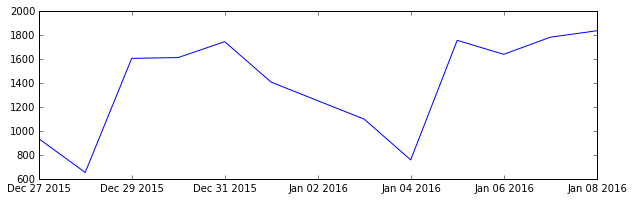

In [11]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

#####Q5. Combine turnstiles at each ControlArea/Unit/Station combination.

In [13]:
units = defaultdict(list)

# make keys CA/Unit/Station
for k, v in daily.iteritems():
    key = k[0:2]+k[3:]
    if key not in units:
        units[key] = []
    units[key].append(daily[k])

chal5 = defaultdict(list)

# unzip dates in {units} values
# sum up entries across the same date
# re-populate new dict {chal5}
for k, v in units.items():
    v = zip(*v)
    chal5[k] = []
    for dt in v:
        dtsum = 0
        for turnstile in dt:
            dtsum += turnstile[1]
        dtpair = [dt[0][0], dtsum]
        chal5[k].append(dtpair)

In [14]:
chal5['A002','R051','59 ST'][0:10]

[[datetime.date(2016, 1, 3), 10830],
 [datetime.date(2016, 1, 4), 7982],
 [datetime.date(2016, 1, 5), 17156],
 [datetime.date(2016, 1, 6), 16463],
 [datetime.date(2016, 1, 7), 17865],
 [datetime.date(2016, 1, 8), 17924],
 [datetime.date(2015, 12, 27), 8885],
 [datetime.date(2015, 12, 28), 7751],
 [datetime.date(2015, 12, 29), 16091],
 [datetime.date(2015, 12, 30), 15811]]

######Q6. Aggregate to station-level

In [16]:
# same as above. probs should've modularized in some way.
temp6 = defaultdict(list)
# make temp list and populate with keys of stations
for k, v in chal5.iteritems():
    key = k[2]
    temp6[key].append(chal5[k])

station = defaultdict(list)

for k, v in temp6.items():
    v = zip(*v)
    for dt in v:
        dtsum = 0
        for unit in dt:
            dtsum += unit[1]
        dtpair = [dt[0][0], dtsum]
        station[k].append(dtpair)

#####Q7. Plot time-series for a station

In [20]:
# sample some stations
sample = [key for key in station.keys()[0:50]]
print sample

['CYPRESS AV', '5 AV/53 ST', 'NEWKIRK PLAZA', 'PATH WTC', 'HUNTS POINT AV', 'SUTTER AV', '149/GRAND CONC', 'BROAD ST', 'GRAND-NEWTOWN', 'EASTCHSTER/DYRE', 'HIGH ST', 'BEVERLY RD', 'ATLANTIC AV', 'WAKEFIELD/241', 'CROWN HTS-UTICA', 'VAN SICLEN AV', 'BEVERLEY ROAD', '18 AV', 'BRIARWOOD', '135 ST', 'CORTELYOU RD', 'LORIMER ST', '21 ST-QNSBRIDGE', 'VAN SICLEN AVE', 'SUTPHIN-ARCHER', '67 AV', 'BAY RIDGE AV', 'NECK RD', 'CYPRESS HILLS', '3 AV 138 ST', '14TH STREET', 'W 8 ST-AQUARIUM', '42 ST-BRYANT PK', 'BEACH 67 ST', '71 ST', 'NEWARK C', 'PRESIDENT ST', '116 ST-COLUMBIA', 'SUTTER AV-RUTLD', 'KOSCIUSZKO ST', '3 AV', 'BRONX PARK EAST', '8 ST-NYU', 'TIMES SQ-42 ST', '75 ST-ELDERTS', 'GROVE STREET', 'QUEENS PLAZA', 'CASTLE HILL AV', 'FRANKLIN AV', "B'WAY-LAFAYETTE"]


In [19]:
dates_station = [d for d, c in sorted(station['CROWN HTS-UTICA'])]
counts_station = [c for d, c in sorted(station['CROWN HTS-UTICA'])]

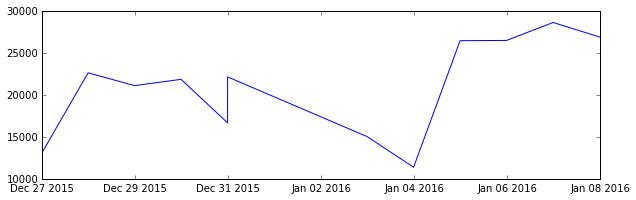

In [21]:
plt.figure(figsize=(10,3))
plt.plot(dates_station, counts_station)